In [1]:
# Importing Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

In [2]:
# Importing team_details.xlsx and creating the dataframe

team = pd.read_excel('team_detail.xlsx')
team.head()

,match_id,home_team_name,Team_id,Team_name,Team_short_name,Team_Points_total,Team_Points_all_out,Team_Points_extras,Team_Points_declare,Team_Raid_Points_total,...,winning_team,toss_winner,venue,toss_choice,toss_direction,winning_score,loosing_score,Year,Month,Season
0,1,U Mumba,3,Jaipur Pink Panthers,JAI,28,2,0,0,25,...,U Mumba,U Mumba,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Right,45,31,2014,7,Season 1
1,1,U Mumba,5,U Mumba,MUM,44,4,0,0,28,...,U Mumba,U Mumba,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Right,45,31,2014,7,Season 1
2,2,TBC,1,Bengaluru Bulls,BEN,42,6,0,0,23,...,Bengaluru Bulls,Dabang Delhi K.C.,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Left,47,28,2014,7,Season 1
3,2,TBC,2,Dabang Delhi K.C.,DEL,28,0,0,0,15,...,Bengaluru Bulls,Dabang Delhi K.C.,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Left,47,28,2014,7,Season 1
4,3,TBC,1,Bengaluru Bulls,BEN,39,4,1,0,20,...,Bengaluru Bulls,Bengaluru Bulls,"DOME@NSCI SVP Stadium, Mumbai",Choice of court,Right,40,37,2014,7,Season 1


In [3]:
team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Data columns (total 34 columns):
match_id                            1272 non-null int64
home_team_name                      1272 non-null object
Team_id                             1272 non-null int64
Team_name                           1272 non-null object
Team_short_name                     1272 non-null object
Team_Points_total                   1272 non-null int64
Team_Points_all_out                 1272 non-null int64
Team_Points_extras                  1272 non-null int64
Team_Points_declare                 1272 non-null int64
Team_Raid_Points_total              1272 non-null int64
Team_Raid_Points_touch              1272 non-null int64
Team_Raid_Points_raid_bonus         1272 non-null int64
Team_Tackle_Points_total            1272 non-null int64
Team_Tackle_Points_capture          1272 non-null int64
Team_Tackle_Points_capture_bonus    1272 non-null int64
Team_Raids_total                    1272 non-null 

In [4]:
# Dropping Match_ID & Date columns as not required in our analysis

team.drop(['match_id','date'],axis=1,inplace=True)
team.shape

(1272, 32)

In [5]:
# Replacing TBC with None as it seems to be same wherein the venue is not the home location for either of the teams playing
team['home_team_name']=team['home_team_name'].replace({'TBC':'None'})

# Consolidating Delhi team's names
team['Team_name']=team['Team_name'].replace({'Dabang Delhi':'Dabang Delhi K.C.'})
team['winning_team']=team['winning_team'].replace({'Dabang Delhi':'Dabang Delhi K.C.'})
team['toss_winner']=team['toss_winner'].replace({'Dabang Delhi':'Dabang Delhi K.C.'})


# Converting Toss_Choice from object to boolean where Toss_Choice is 0 if toss_choice is "Choice of Raid" & 1 if toss_choice is 
# choice of court
team['toss_choice']=team['toss_choice'].apply(lambda x: 1 if x=='Choice of court' else 0)

# Converting Toss Direction from object to boolean where Toss_direction is 1 is toss direction is right else 0 if toss
# direction is left
team['toss_direction']=team['toss_direction'].apply(lambda x: 1 if x.strip=='Right' else 0)

# Converting home_team_name to 1 home team name is same as team name else converting it to 0
team['home_team_name']=(team['home_team_name']==team['Team_name']).apply(lambda x: 1 if x==True else 0)

# Converting winning_team to 1 winning team same is same as team name else converting it to 0
team['winning_team']=(team['winning_team']==team['Team_name']).apply(lambda x: 1 if x==True else 0)

# Converting toss_winner to 1 if toss winner team same is same as team name else converting it to 0
team['toss_winner']=(team['toss_winner']==team['Team_name']).apply(lambda x: 1 if x==True else 0)

team.head()

,home_team_name,Team_id,Team_name,Team_short_name,Team_Points_total,Team_Points_all_out,Team_Points_extras,Team_Points_declare,Team_Raid_Points_total,Team_Raid_Points_touch,...,winning_team,toss_winner,venue,toss_choice,toss_direction,winning_score,loosing_score,Year,Month,Season
0,0,3,Jaipur Pink Panthers,JAI,28,2,0,0,25,22,...,0,0,"DOME@NSCI SVP Stadium, Mumbai",0,0,45,31,2014,7,Season 1
1,1,5,U Mumba,MUM,44,4,0,0,28,23,...,1,1,"DOME@NSCI SVP Stadium, Mumbai",0,0,45,31,2014,7,Season 1
2,0,1,Bengaluru Bulls,BEN,42,6,0,0,23,22,...,1,0,"DOME@NSCI SVP Stadium, Mumbai",0,0,47,28,2014,7,Season 1
3,0,2,Dabang Delhi K.C.,DEL,28,0,0,0,15,8,...,0,1,"DOME@NSCI SVP Stadium, Mumbai",0,0,47,28,2014,7,Season 1
4,0,1,Bengaluru Bulls,BEN,39,4,1,0,20,15,...,1,1,"DOME@NSCI SVP Stadium, Mumbai",0,0,40,37,2014,7,Season 1


In [6]:
for i in range(0,len(team)):
    if team.loc[i,'winning_team'] == 1:
        team.loc[i,'winning_margin'] = team.loc[i,'winning_score'] - team.loc[i,'loosing_score']
    else:
        team.loc[i,'winning_margin'] = team.loc[i,'loosing_score'] - team.loc[i,'winning_score']

In [7]:
team.to_excel('team_data_model.xlsx',index=False)

In [8]:
# Storing Team Name in different dataframe to map it to the prediction later. 
team_name=team['Team_name']

# dropping some columns which doesn't look required for analysis
cols_to_drop=['venue','Team_name','Team_short_name','Year','Month','start_time','Team_id','Team_Raids_total',
              'Team_Raid_Points_touch','winning_score','loosing_score']
team=team.drop(cols_to_drop, axis=1)

# Converting season column to category 
team['Season']=team['Season'].astype('category')

team.shape

(1272, 22)

In [9]:
team.head()

,home_team_name,Team_Points_total,Team_Points_all_out,Team_Points_extras,Team_Points_declare,Team_Raid_Points_total,Team_Raid_Points_raid_bonus,Team_Tackle_Points_total,Team_Tackle_Points_capture,Team_Tackle_Points_capture_bonus,...,Team_Raids_Empty,Team_Tackles_total,Team_Tackles_successful,Team_Tackles_unsuccessful,winning_team,toss_winner,toss_choice,toss_direction,Season,winning_margin
0,0,28,2,0,0,25,3,1,1,0,...,10,24,1,23,0,0,0,0,Season 1,-14.0
1,1,44,4,0,0,28,5,12,12,0,...,15,32,10,22,1,1,0,0,Season 1,14.0
2,0,42,6,0,0,23,1,13,13,0,...,10,21,13,8,1,0,0,0,Season 1,19.0
3,0,28,0,0,0,15,7,13,13,0,...,10,33,11,22,0,1,0,0,Season 1,-19.0
4,0,39,4,1,0,20,5,14,14,0,...,15,26,13,13,1,1,0,0,Season 1,3.0


### Create Model

In [10]:
print(team.select_dtypes(include='object'))

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[1272 rows x 0 columns]


#### _There is nothing to dummify_

In [11]:
# Creating train and test. We will test the model on Season 7 data

train=team[team['Season']!='Season 7']

test=team[team['Season']=='Season 7']

# Dropping Season column as it is no more required. The test and train data has been split basis the season
y_train=train['Team_Raids_successful']
train=train.drop(['Season','Team_Raids_successful'], axis=1)


y_test=test['Team_Raids_successful']
test=test.drop(['Season','Team_Raids_successful'], axis=1)

print("Train Data Shape is: ", train.shape)
print("Test Data Shape is: ", test.shape)

Train Data Shape is:  (1040, 20)
Test Data Shape is:  (232, 20)


#### _I am not removing any other data. Will let Lasso take that call_

In [12]:
# Creating target variable which is Touch points as we need to identify which team will be having highest successful raid points
# for train data set


print('Train Shape is', train.shape)
print('y_train Shape is', y_train.shape)

Train Shape is (1040, 20)
y_train Shape is (1040,)


In [13]:
# Creating target variable which is Touch points as we need to identify which team will be having highest successful raid points
# for test data set

print('Test Shape is', test.shape)
print('y_test Shape is', y_test.shape)

Test Shape is (232, 20)
y_test Shape is (232,)


In [14]:
# Scaling the features
# storing the columns in a variable for avoiding them from lossing after scaling
X_train_cols=train.columns

scaler=StandardScaler()
train[X_train_cols]=scaler.fit_transform(train[X_train_cols])

train.head()

,home_team_name,Team_Points_total,Team_Points_all_out,Team_Points_extras,Team_Points_declare,Team_Raid_Points_total,Team_Raid_Points_raid_bonus,Team_Tackle_Points_total,Team_Tackle_Points_capture,Team_Tackle_Points_capture_bonus,Team_Raids_unsuccessful,Team_Raids_Empty,Team_Tackles_total,Team_Tackles_successful,Team_Tackles_unsuccessful,winning_team,toss_winner,toss_choice,toss_direction,winning_margin
0,-0.503003,-0.455681,-0.177082,-1.148447,0.0,1.244141,-0.329941,-2.536457,-2.467952,-0.682528,0.167896,-1.793128,0.251199,-2.456764,1.791561,-0.899275,-1.0,0.0,0.0,-1.336730
1,1.988060,1.633172,0.857554,-1.148447,0.0,1.778298,0.431742,0.746760,1.026277,-0.682528,-1.716403,-0.760312,1.954522,0.424854,1.589191,1.112007,1.0,0.0,0.0,1.336730
2,-0.503003,1.372066,1.892190,-1.148447,0.0,0.888036,-1.091624,1.045234,1.343934,-0.682528,0.481946,-1.793128,-0.387547,1.385393,-1.243994,1.112007,-1.0,0.0,0.0,1.814134
3,-0.503003,-0.455681,-1.211718,-1.148447,0.0,-0.536383,1.193426,1.045234,1.343934,-0.682528,2.366244,-1.793128,2.167437,0.745034,1.589191,-0.899275,1.0,0.0,0.0,-1.814134
4,-0.503003,0.980405,0.857554,-0.447105,0.0,0.353879,0.431742,1.343708,1.661591,-0.682528,0.795995,-0.760312,0.677030,1.385393,-0.232142,1.112007,1.0,0.0,0.0,0.286442


In [15]:
# Scaling the test data
test[X_train_cols]=scaler.transform(test[X_train_cols])
test.head()

,home_team_name,Team_Points_total,Team_Points_all_out,Team_Points_extras,Team_Points_declare,Team_Raid_Points_total,Team_Raid_Points_raid_bonus,Team_Tackle_Points_total,Team_Tackle_Points_capture,Team_Tackle_Points_capture_bonus,Team_Raids_unsuccessful,Team_Raids_Empty,Team_Tackles_total,Team_Tackles_successful,Team_Tackles_unsuccessful,winning_team,toss_winner,toss_choice,toss_direction,winning_margin
1028,-0.503003,0.849852,0.857554,0.254236,0.0,0.709984,0.431742,0.149811,0.390963,-0.682528,-0.146154,0.065941,0.038284,0.424854,-0.232142,1.112007,-1.0,0.0,0.0,0.668365
1029,-0.503003,-0.064021,-0.177082,0.254236,0.0,-0.180278,0.050901,0.149811,-0.244352,1.187904,0.795995,-0.347185,0.464114,-0.215506,0.577339,-0.899275,1.0,0.0,0.0,-0.668365
1030,-0.503003,0.849852,0.857554,-0.447105,0.0,1.422193,0.050901,-0.745612,-0.562009,-0.682528,-0.146154,-1.380002,0.251199,-0.535685,0.577339,1.112007,1.0,0.0,0.0,0.477404
1031,-0.503003,0.197085,-0.177082,0.955578,0.0,0.353879,-0.329941,-0.447137,-0.244352,-0.682528,-0.774253,-0.140622,1.528691,-0.215506,1.589191,-0.899275,-1.0,0.0,0.0,-0.477404
1044,1.988060,-0.847341,-1.211718,-1.148447,0.0,-0.536383,1.574267,0.149811,0.073305,0.252688,0.481946,-0.760312,0.251199,0.104674,0.172599,-0.899275,-1.0,0.0,0.0,-0.572884


In [16]:
# Defining alphas for identiying the optimum alphas for Lasso regression
params = {'alpha': [0.00000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,
                    0.6,0.7,0.8,0.9]}

# Lasso Modelling
lasso = Lasso()

# cross validation
folds=5
lasso_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_cv.fit(train, y_train) 

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    0.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-11, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                   0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4,
                                   0.5, 0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [17]:
# Printing the model output

lasso_cv_results = pd.DataFrame(lasso_cv.cv_results_)
lasso_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.095288,0.175105,0.006255,0.012510,1e-11,{'alpha': 1e-11},-1.382334,-1.368222,-1.308588,-1.211438,...,-1.345091,0.081449,6,-1.314133,-1.295119,-1.326343,-1.352326,-1.251401,-1.307864,0.033788
1,0.012499,0.006250,0.000000,0.000000,1e-08,{'alpha': 1e-08},-1.382334,-1.368222,-1.308588,-1.211438,...,-1.345091,0.081449,5,-1.314133,-1.295119,-1.326343,-1.352326,-1.251401,-1.307864,0.033788
2,0.003124,0.006249,0.003125,0.006249,1e-07,{'alpha': 1e-07},-1.382333,-1.368222,-1.308588,-1.211438,...,-1.345091,0.081449,4,-1.314133,-1.295119,-1.326343,-1.352326,-1.251402,-1.307864,0.033788
3,0.005037,0.002809,0.000399,0.000489,1e-06,{'alpha': 1e-06},-1.382327,-1.368224,-1.308588,-1.211440,...,-1.345091,0.081448,3,-1.314134,-1.295119,-1.326344,-1.352327,-1.251403,-1.307865,0.033788
4,0.012499,0.006249,0.000000,0.000000,1e-05,{'alpha': 1e-05},-1.382266,-1.368246,-1.308590,-1.211457,...,-1.345089,0.081440,2,-1.314142,-1.295123,-1.326358,-1.352338,-1.251416,-1.307875,0.033788


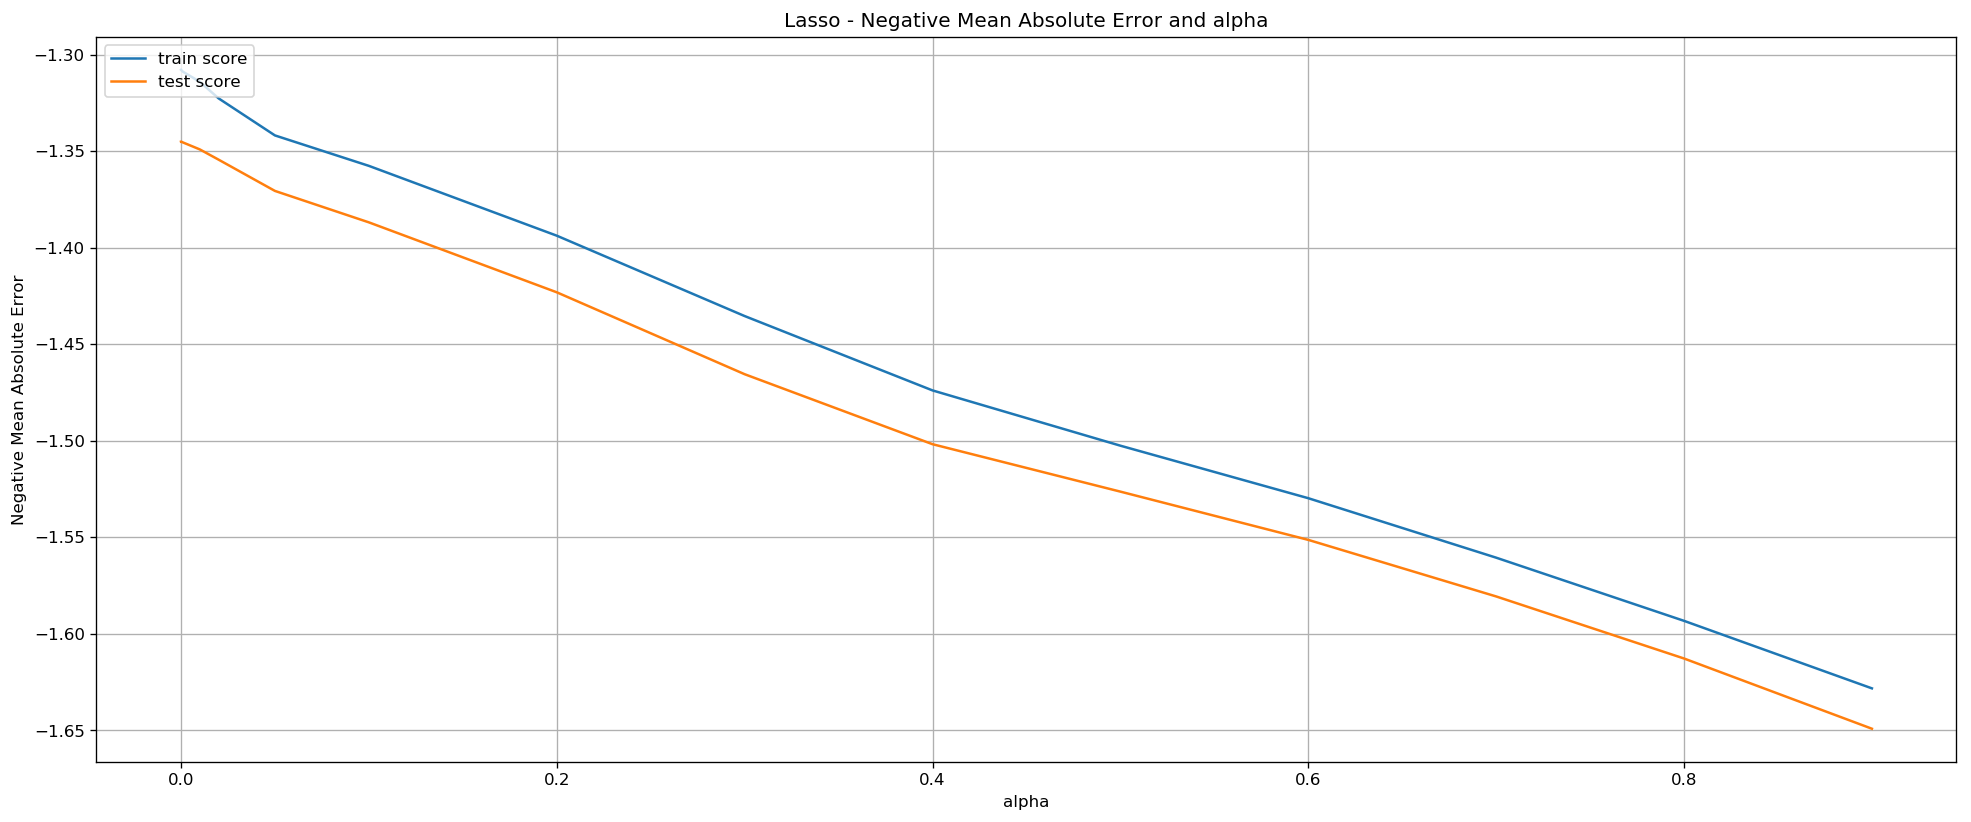

In [18]:
# plotting mean test and train scoes with alpha 
lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float32')

# plotting
plt.figure(num=None, figsize=(20, 8), dpi=120, facecolor='w', edgecolor='k')
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Lasso - Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.grid()
plt.show()

In [19]:
print(lasso_cv.best_params_['alpha'])

0.0001


In [20]:
alpha = lasso_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)
lasso.fit(train, y_train) 

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [21]:
lasso.score(train, y_train)

0.8524586896346448

In [22]:
lasso.score(test, y_test)

0.8747132989836128

In [23]:
y_test_pred=lasso.predict(test)
print(r2_score(y_test,y_test_pred))
print(np.sqrt(mean_squared_error(y_test,y_test_pred)))

0.8747132989836128
1.4838526880274263


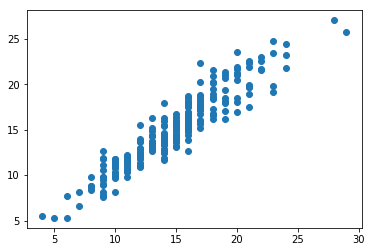

In [24]:
plt.scatter(y_test,y_test_pred)

In [25]:
features = np.abs(pd.Series(dict(zip(train.columns,lasso.coef_)))).sort_values(ascending=False)
print(features)

Team_Points_total                   2.517237
Team_Raid_Points_total              2.173009
Team_Tackle_Points_total            1.552172
Team_Points_all_out                 0.895194
Team_Raids_unsuccessful             0.749167
Team_Tackle_Points_capture          0.629610
Team_Raids_Empty                    0.563200
Team_Tackles_successful             0.554611
winning_margin                      0.552052
winning_team                        0.159777
Team_Points_extras                  0.143691
Team_Raid_Points_raid_bonus         0.131188
Team_Tackle_Points_capture_bonus    0.071315
Team_Tackles_unsuccessful           0.068643
home_team_name                      0.055666
toss_winner                         0.013331
toss_direction                      0.000000
Team_Tackles_total                  0.000000
Team_Points_declare                 0.000000
toss_choice                         0.000000
dtype: float64


In [26]:
raider_team = pd.DataFrame(np.array([team_name.loc[test.index].values,y_test_pred]).T,columns=['Team','Raid Points'])
raider_team['Successful Raid Points'] = raider_team['Raid Points'].astype(int)
raider_team = raider_team[['Team','Successful Raid Points']].groupby('Team').sum().sort_values(by='Successful Raid Points',ascending=False)
raider_team.head()

,Successful Raid Points
Team,
Dabang Delhi K.C.,329
Bengaluru Bulls,318
Bengal Warriors,312
Haryana Steelers,292
Puneri Paltan,288
